In [2]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

In [3]:
print("Train size: ", len(train_mnist))
print("Test size: ", len(test_mnist))

Train size:  60000
Test size:  10000


In [4]:
digit, cls = train_mnist[1]

print(digit.shape)
print(cls)

print(digit.mean())
print(digit.std())

torch.Size([1, 28, 28])
0
tensor(0.0806)
tensor(1.0684)


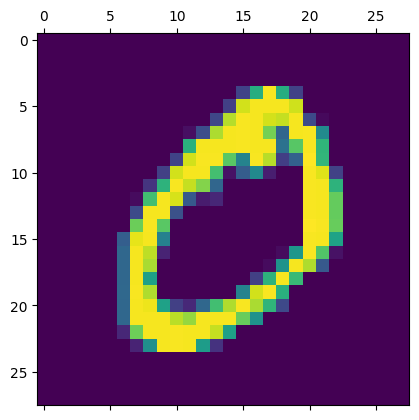

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.matshow(digit[0])

In [31]:
class CNNClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, (3, 3)),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 32, (4, 4), stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, (5, 5), stride=2),
            torch.nn.LeakyReLU()
        )

        self.ff = torch.nn.Sequential(
            torch.nn.Linear(1024, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300 ,300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 10),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        features = self.cnn(x)
        features = features.view(features.shape[0], -1)
        
        prob = self.ff(features)

        return prob

dl = torch.utils.data.DataLoader(train_mnist, batch_size=8, shuffle=True)
cnn = CNNClassifier()

digits, classes = next(iter(dl))

out = cnn(digits)
print(out.shape)
print(out.sum(dim=1))

torch.Size([8, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


In [33]:
from tqdm import tqdm
import wandb

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
model = CNNClassifier()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model = model.to("cuda")
wandb.init()

for epoch in range(3):
    bar = tqdm(dl)
    for digit, classes in bar:
        digit = digit.to("cuda")
        classes = classes.to("cuda")

        pred = model(digit)
        loss = loss_fn(pred, classes)

        acc = (pred.argmax(dim=1) == classes).float().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_description(f"loss: {loss.item():.2f}  acc: {acc.item():.2f}")

        wandb.log(dict(
            loss=loss.item(),
            acc=acc.item()
        ))
        



acc,▁▂▆▅█▄▇▆▇▅▅█▅▆▄▆▅▆▅▅▅▅▅▆▄▇▅▁▅▅▅▆▄▆▄▅▅▁▂▄
loss,█▇▃▄▁▅▂▃▂▄▄▁▄▃▅▃▄▃▄▄▄▄▄▃▅▂▄█▄▄▄▃▅▃▅▄▄█▇▅
acc,0.65625
loss,1.80543


loss: 1.47  acc: 1.00: 100%|██████████| 1875/1875 [00:09<00:00, 190.47it/s]
